# In deze notebook wordt aangetoond hoe we de dataexploratiefase hadden kunnen aanpakken indien we toen al met Pandas konden werken.  

In [1]:
import pandas as pd
import geopandas
from geopandas import GeoDataFrame
from pandas import Series
from shapely.geometry import Point, MultiPoint, LineString, MultiLineString, Polygon
import itertools
import numpy as np
import math
import matplotlib.pyplot as plt
import time
import datetime 
import random
import calendar

In [2]:
def ReadData(bestand):
    
    kolommen = ['bird_name','date_time','colony_latitude', 'colony_longitude','longitude','latitude','direction','behaviour','calc_time_diff']

    data = pd.read_csv( bestand, usecols=kolommen, sep=',' ,header=(0),low_memory=False, parse_dates=['date_time'], dayfirst=True)

    return data

In [3]:
data = ReadData(r'C:\Users\maart\OneDrive\Master\Projectwerk Geo-ICT\data.geo.ict.csv')


In [4]:
data.head()

,bird_name,colony_latitude,colony_longitude,date_time,latitude,longitude,direction,calc_time_diff,behaviour
0,Anne,51.233056,2.930977,2013-05-24 18:23:38,51.234973,2.911094,-114.597483,NaN,NaN
1,Anne,51.233056,2.930977,2013-05-24 18:28:30,51.238514,2.912785,120.554176,292.0,NaN
2,Anne,51.233056,2.930977,2013-05-24 18:33:16,51.238521,2.912806,121.946317,286.0,NaN
3,Anne,51.233056,2.930977,2013-05-24 18:38:04,51.238514,2.912814,-167.589902,288.0,NaN
4,Anne,51.233056,2.930977,2013-05-24 18:42:53,51.236735,2.913930,130.768220,289.0,NaN


## Welke meeuwen

In [5]:
meeuwen = list(data.bird_name.unique())
print(meeuwen)

['Anne', 'Bram', 'Brigitte', 'Catia', 'Ceryl', 'Claude', 'Dre', 'Eva', 'Fien', 'Francis', 'Geert', 'Hein', 'Hilde', 'Jan', 'Joanna', 'Joost', 'Jurgen', 'Karen', 'Koen', 'Leslie', 'Lilian', 'Louise', 'Luc', 'Magda', 'Maurice', 'Mia', 'Mirte', 'Nicky', 'Niels', 'Rik', 'Robin', 'Rolanda', 'Rudy', 'Sander', 'Silke', 'Stefanie', 'Suk-hyo', 'Tatiana', 'Tessa', 'Tine', 'Tjess', 'Veronic', 'Wendy', 'Wilma', 'Wim']


## Langst getraceerde meeuwen

In [6]:
mTI = data.groupby('bird_name')['date_time'].describe()[['first', 'last']]
mTI['timespan'] = mTI['last']-mTI['first']

mTI = mTI.sort_values(by=['timespan'], ascending=False)
langsteTI = list(mTI.head().index.values)
mTI.head()

,first,last,timespan
bird_name,,,
Jurgen,2013-05-17 18:05:26,2017-08-31 15:51:23,1566 days 21:45:57
Wilma,2013-05-27 18:21:31,2017-08-31 19:56:36,1557 days 01:35:05
Luc,2013-05-27 18:09:03,2017-08-23 14:44:50,1548 days 20:35:47
Anne,2013-05-24 18:23:38,2016-10-27 18:33:47,1252 days 00:10:09
Tjess,2014-05-30 18:04:34,2017-08-13 03:31:45,1170 days 09:27:11


## Meeuwen met het meeste aantal trackingpoints

In [7]:
"""Meeuwen rangschikken op meeste aantal trackingpoints"""
pointcount = data.groupby('bird_name')['date_time'].count().sort_values(ascending=False).head()
meestepunten = list(pointcount.head().index.values)
pointcount.head()

bird_name
Catia     496299
Joanna    369179
Tjess     333590
Magda     326973
Hein      325771
Name: date_time, dtype: int64

In [8]:
vijfmeeuwen = random.sample(meeuwen,k=5)
vijfmeeuwen

['Wim', 'Stefanie', 'Rolanda', 'Claude', 'Leslie']

In [9]:
trackingpoints =  data.set_index('date_time')
trackingpoints.head()

,bird_name,colony_latitude,colony_longitude,latitude,longitude,direction,calc_time_diff,behaviour
date_time,,,,,,,,
2013-05-24 18:23:38,Anne,51.233056,2.930977,51.234973,2.911094,-114.597483,NaN,NaN
2013-05-24 18:28:30,Anne,51.233056,2.930977,51.238514,2.912785,120.554176,292.0,NaN
2013-05-24 18:33:16,Anne,51.233056,2.930977,51.238521,2.912806,121.946317,286.0,NaN
2013-05-24 18:38:04,Anne,51.233056,2.930977,51.238514,2.912814,-167.589902,288.0,NaN
2013-05-24 18:42:53,Anne,51.233056,2.930977,51.236735,2.913930,130.768220,289.0,NaN


## Plot aantal trackingpoints per maand

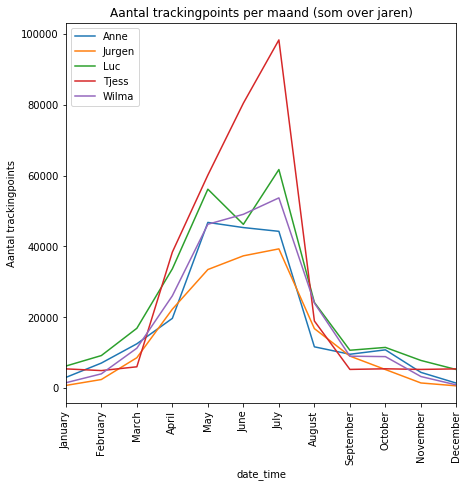

In [10]:
fig, ax = plt.subplots()

for bird, bird_data in trackingpoints.loc[trackingpoints.bird_name.isin(langsteTI)].groupby('bird_name'):
    bird_data.bird_name.groupby([bird_data.index.month]).count().plot(ax=ax, figsize=(7, 7), alpha=1, label=bird)

    
ax.set_xticks([i for i in range(1,13)])
ax.set_xticklabels(list(calendar.month_name)[1:], rotation='vertical')
plt.ylabel('Aantal trackingpoints')
plt.title("Aantal trackingpoints per maand (som over jaren)")
plt.legend(loc='upper left')
plt.show()

## Plot gemiddelde tijdsprong tussen datapoints

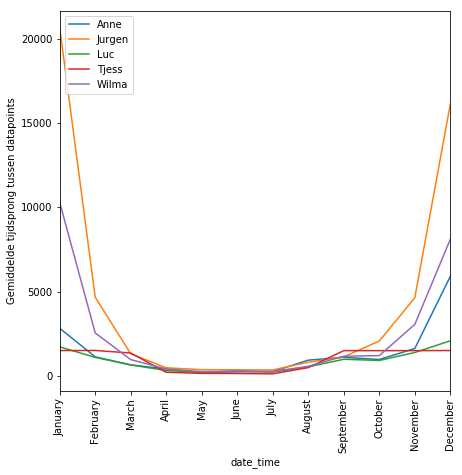

In [11]:
selectie_meeuwen = langsteTI

fig, ax = plt.subplots()
for bird, bird_data in trackingpoints.loc[trackingpoints.bird_name.isin(selectie_meeuwen)].groupby('bird_name'):
    bird_data.calc_time_diff.groupby(bird_data.index.month).mean().plot(ax=ax, figsize=(7, 7), alpha=1, label=bird)

ax.set_xticks([i for i in range(1,13)])
ax.set_xticklabels(list(calendar.month_name)[1:], rotation='vertical')
plt.ylabel('Gemiddelde tijdsprong tussen datapoints')
plt.legend(loc='upper left')
plt.show()

## Plot temporele resoluties

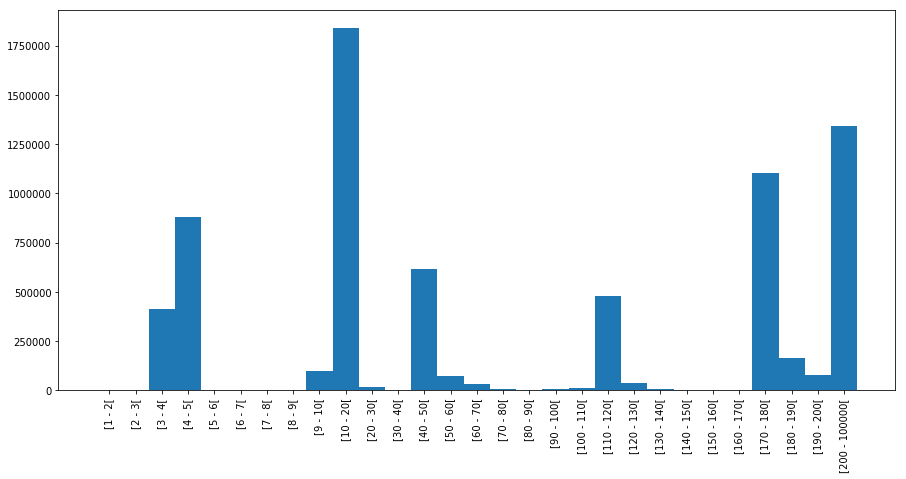

In [12]:
import numpy as np
import matplotlib.pyplot as plt

bins = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200, 100000] # your bins
data_plot = trackingpoints.calc_time_diff

hist, bin_edges = np.histogram(data_plot,bins) # make the histogram

fig,ax = plt.subplots(figsize=(15, 7))

# Plot the histogram heights against integers on the x axis
ax.bar(range(len(hist)),hist,width=1) 

# Set the ticks to the middle of the bars
ax.set_xticks([i for i,j in enumerate(hist)])

# Set the xticklabels to a string that tells us what the bin edges were
ax.set_xticklabels(['[{} - {}['.format(bins[i],bins[i+1]) for i,j in enumerate(hist)], rotation='vertical')

plt.show()

In [13]:
kolonie_meeuw = data.groupby('bird_name')[['colony_longitude', 'colony_latitude']].min()
kolonie_meeuw.columns = ['longitude', 'latitude']
punt = [Point(xy) for xy in zip(kolonie_meeuw.longitude,kolonie_meeuw.latitude)]
crs= {'init': 'epsg:4326'}
kolonie_meeuw = GeoDataFrame(kolonie_meeuw, crs= crs, geometry=punt).to_crs(epsg=31370)
kolonie_dict = dict()
for (longitude,latitude), groep in kolonie_meeuw.groupby(['longitude','latitude']):
    kolonie_dict.update({(longitude, latitude):groep.index.values})
kolonie_dict


{(2.922957, 51.231921): array(['Jan', 'Robin'], dtype=object),
 (2.930977,
  51.233056): array(['Anne', 'Catia', 'Ceryl', 'Dre', 'Eva', 'Fien', 'Francis', 'Geert',
        'Hein', 'Hilde', 'Joanna', 'Joost', 'Jurgen', 'Karen', 'Koen',
        'Leslie', 'Lilian', 'Louise', 'Luc', 'Magda', 'Maurice', 'Mia',
        'Mirte', 'Nicky', 'Rolanda', 'Rudy', 'Stefanie', 'Suk-hyo',
        'Tessa', 'Tjess', 'Veronic', 'Wilma'], dtype=object),
 (3.17362,
  51.34894): array(['Bram', 'Brigitte', 'Claude', 'Niels', 'Rik', 'Sander', 'Silke',
        'Tatiana', 'Tine', 'Wendy', 'Wim'], dtype=object)}